In [1]:
import math
import matplotlib.pyplot as plt
import torch

from azula.guidance import MMPSDenoiser
from azula.sample import LMSSampler, PCSampler
from einops import rearrange
from functools import partial
from omegaconf import OmegaConf
from pathlib import Path

from lpdm.data import field_preprocess, get_well_multi_dataset
from lpdm.diffusion import get_autoencoder, get_denoiser
from lpdm.plot import animate_fields, draw_fields

plt.rcParams["animation.ffmpeg_path"] = "/mnt/sw/nix/store/fz8y69w4c97lcgv1wwk03bd4yh4zank7-ffmpeg-full-6.0-bin/bin/ffmpeg"  # fmt: off
plt.rcParams["animation.html"] = "html5"

_ = torch.manual_seed(0)

/mnt/home/frozet/mpp-ldm/lpdm/nn/attention.py:9: FutureWarning: xformers.components is deprecated and is not maintained anymore. It might be removed in a future version of xFormers 
  import xformers.components.attention.core as xfa


In [2]:
runpath = Path("/mnt/ceph/users/frozet/mpp-ldm/runs/mfhuqc5c_unet_medium_soap_3e-05_0.0_cosine_1")  # fmt: off
cfg = OmegaConf.load(runpath / "config.yaml")
device = "cuda"

## Data

In [3]:
rollout_length = 17

testset = get_well_multi_dataset(
    path="/mnt/ceph/users/polymathic/the_well/datasets",
    physics=cfg.dataset.physics,
    split="test",
    steps=rollout_length,
    dt_stride=cfg.trajectory.stride,
    include_filters=cfg.dataset.include_filters,
)

preprocess = partial(
    field_preprocess,
    mean=torch.as_tensor(cfg.dataset.stats.mean, device=device),
    std=torch.as_tensor(cfg.dataset.stats.std, device=device),
    transform=cfg.dataset.transform,
)

## Autoencoder

In [4]:
autoencoder = get_autoencoder(
    pix_channels=testset.metadata.n_fields,
    **cfg.ae,
)

state = torch.load(runpath / "autoencoder/state.pth", weights_only=True)

if "predictor" in state:
    autoencoder.load_state_dict(state["autoencoder"])
else:
    autoencoder.load_state_dict(state)

autoencoder.cuda()
autoencoder.eval()

AutoEncoder(
  (encoder): Encoder(
    (descent): ModuleList(
      (0): ModuleList(
        (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ResBlock(
          (attn): Identity()
          (block): Sequential(
            (0): LayerNorm(dim=-3)
            (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): SiLU()
            (3): Identity()
            (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
      )
      (1): ModuleList(
        (0): Sequential(
          (0): Patchify()
          (1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1-2): 2 x ResBlock(
          (attn): Identity()
          (block): Sequential(
            (0): LayerNorm(dim=-3)
            (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): SiLU()
            (3): Identity()
            (4): Conv2d(128, 128, kernel_si

## Denoiser

In [5]:
if "f8" in cfg.ae.name:
    shape = (cfg.ae.lat_channels, cfg.trajectory.length, 64, 64)
elif "f32" in cfg.ae.name:
    shape = (cfg.ae.lat_channels, cfg.trajectory.length, 16, 16)

denoiser = get_denoiser(
    shape=shape,
    label_features=testset.metadata.n_constant_scalars,
    **cfg.denoiser,
)

denoiser.load_state_dict(torch.load(runpath / "state_ema.pth", weights_only=True))
denoiser.cuda()
denoiser.eval()

PreconditionedDenoiser(
  (backbone): FlattenWrapper(
    (wrappee): EmbeddingWrapper(
      (backbone): UNet(
        (descent): ModuleList(
          (0): ModuleList(
            (0): Conv3d(8, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (1-3): 3 x UNetBlock(
              (attn): Identity()
              (norm): LayerNorm(dim=-4)
              (ada_zero): Sequential(
                (0): Linear(in_features=256, out_features=256, bias=True)
                (1): SiLU()
                (2): Linear(in_features=256, out_features=384, bias=True)
                (3): Rearrange('... (n C) -> n ... C 1 1 1', n=3)
              )
              (block): Sequential(
                (0): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                (1): SiLU()
                (2): Dropout(p=0.05, inplace=False)
                (3): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
              )
         

In [6]:
sum(p.numel() for p in denoiser.parameters())

204467720

## Evaluation

In [7]:
sampler = LMSSampler(denoiser, steps=64).to(device)

label = torch.tensor([1.13]).to(device)

z1 = sampler.init((1, math.prod(shape)))
z0 = sampler(z1, label=label)
z0 = z0.reshape(shape)

with torch.no_grad():
    x = autoencoder.decode(rearrange(z0, "C L H W -> L C H W"))

x = rearrange(x, "L C H W -> L H W C").cpu()

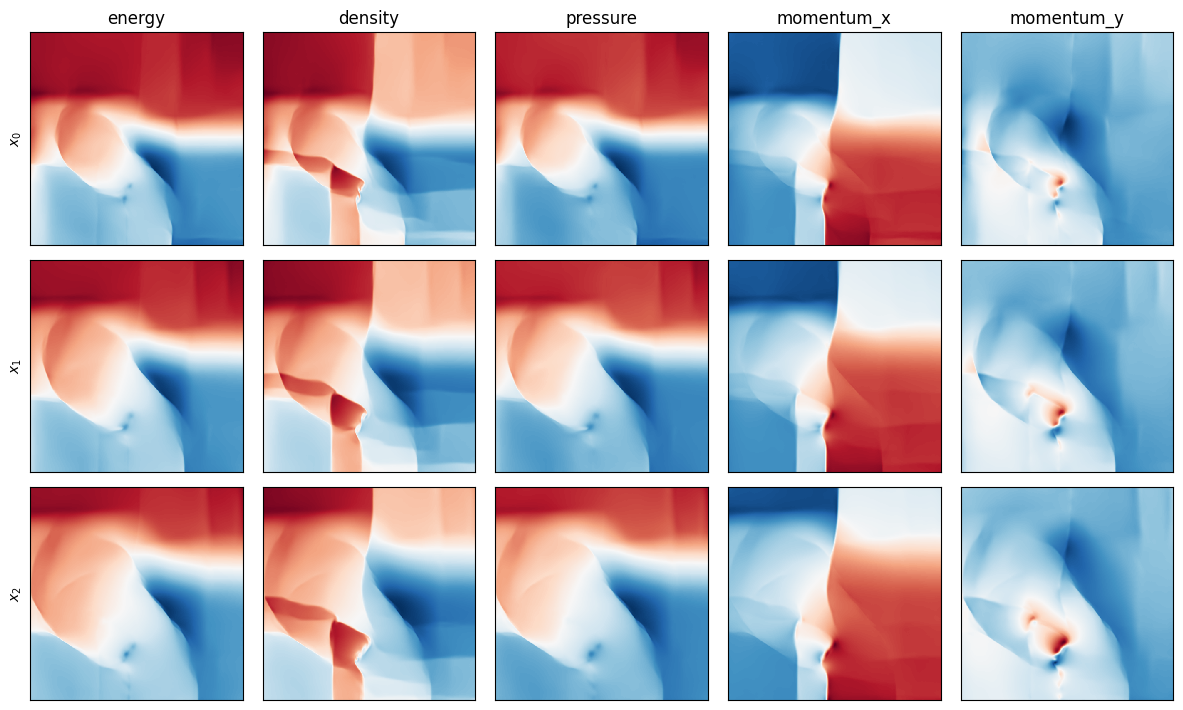

In [8]:
fig = draw_fields(x, fields=cfg.dataset.fields)

## Condition

In [9]:
item = testset[13]
x = item["input_fields"]
x = x.to(device)
x = preprocess(x)
x = rearrange(x, "L H W C -> L C H W")

label = item["constant_scalars"].to(device)

with torch.no_grad():
    z = rearrange(autoencoder.encode(x), "L C H W -> C L H W")

x = rearrange(x, "L C H W -> L H W C").cpu()

In [10]:
def A(z):
    return z.reshape(shape)[:, 0, :, :].reshape(-1)


def infer(A, y):
    cond_denoiser = MMPSDenoiser(
        denoiser,
        A=A,
        y=y,
        var_y=1e-6,
        iterations=3,
    )

    cond_sampler = PCSampler(cond_denoiser, steps=64, corrections=1, delta=0.1).to(device)

    z1 = cond_sampler.init((1, math.prod(shape)))
    z0 = cond_sampler(z1, label=label)
    z0 = z0.reshape(shape)

    with torch.no_grad():
        x_hat = autoencoder.decode(rearrange(z0, "C L H W -> L C H W"))

    x_hat = rearrange(x_hat, "L C H W -> L H W C").cpu()
    return x_hat, z0

In [11]:
y = z[..., :, 0, :, :].reshape(-1)
x_hat, z_hat = infer(A, y)

In [12]:
animation = animate_fields(x[: cfg.trajectory.length], x_hat, fields=cfg.dataset.fields)
display(animation)
plt.close()

## Rollout

In [13]:
y = z[..., :, 0, :, :].reshape(-1)

trajectory = []

while len(trajectory) < rollout_length:
    x_hat, z_hat = infer(A, y)

    if trajectory:
        trajectory.extend(x_hat[1:].unbind(0))
    else:
        trajectory.extend(x_hat.unbind(0))

    y = z_hat[..., :, -1, :, :].reshape(-1)

x_hat = torch.stack(trajectory)

In [14]:
animation = animate_fields(x, x_hat, fields=cfg.dataset.fields)
display(animation)
plt.close()